In [2204]:
!pip install p3_data

In [2205]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [2206]:
import p3_data
from p3_data import (glob_file_list, load_json_from_file, merge_dicts, plot_groups, 
    get_varying_column_names, filter_dataframe, take_varying_columns,
    load_json_records_as_dataframe)

In [2779]:
# Load result files from P3 Test Driver
src_files = []

# Pulsar 2.6.0 ecs s3 tier2 07.07.2020

## attempt1 brokers out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/Pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-18tests-attempt1-broker-outofdirectmem/data/p3_test_driver/results/*.json']

## attempt2 bookies out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt2-bk-outofdirectmem/data/p3_test_driver/results/*.json']

## attempt3 broker out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt3-broker-directmemOOM/data/p3_test_driver/results/*.json']
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt3-broker-directmemOOM/data/p3_test_driver/results_cleared/*.json']

# Pulsar 2.6.0 ecs s3 tier2 07.07.2020
## attempt4 broker out of direct memory - 52 tests
src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-52tests-attempt4/data/p3_test_driver/results_cleared/*.json']

#################s pulsar-2.6.0-no-tiered-10.07.2020-46tests-success
src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-no-tiered-10.07.2020-46tests-success/data/p3_test_driver/results_cleared/*.json']
#---------------------------------------------------------

### Pulsar 2.5.2 15.06.2020 44 tests different amount of workers
# src_files += ['../../../../../tests/pulsar_2.5.2_44_tests_15.06/data/p3_test_driver/results/*.json']

### Pulsar 2.5.2 17.06.2020 44 tests different amount of workers
#src_files += ['../../../../../tests/Pulsar-2.5.2-17.06.20-44tests/data/p3_test_driver/results_cleared/*.json']

#-------------------------------------------------------------------------
############## Pulsar fresh tests 2.5.2 
src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/Pulsar-2.5.2-no_tier2_11.07.2020/pulsar-2.5.2-10k_1p_16p_100b_1p_no_tier2_47tests-11.07.2020/data/p3_test_driver/results/*.json']



# Pravega 0.8.0-2577.15b0f5eb9 tier2 29.06.2020
#src_files += ['../../../../tests/pravega-15b0f5eb9-tier2-29.06.2020-10k-100b/pravega-0.8.0-2577.15b0f5eb9-tier2-10k-28tests-29.06.2020/data/p3_test_driver/results/*.json']

# pravega-0.8.0-2656.1c40f1e-no_netty_Isilon-nfs-tier2 09.07.2020 48 tests success
src_files += ['../../../../../tests/Pravega-1c40f1e-NO_NETTY-nfs-Isilon-tier2-48tests-succsess-09.07.2020/data/p3_test_driver/results/*.json']

### PRAVEGA 15b0f5eb9 (master) Isilon nfs omb 2b28b32 (no_netty) 09.07.2020 48tests success
src_files += ['../../../../../tests/PRAVEGA-15b0f5eb9-Isilon-nfs-omb-2b28b32-09.07.2020-48tests/data/p3_test_driver/results/*.json']

###### PRAVEGA 15b0f5eb9 (master) omb 2b28b32 (no_netty) ECS S3 tier2 13.07.2020
# 10k 1p
src_files += ['../../../../../tests/PRAVEGA-15b0f5eb9-2b28b32-ECS-tier2-13.07.2020/10k-1p/data/p3_test_driver/results_cleared/*.json']
# 10k 16p and 100b 1p 16p
src_files += ['../../../../../tests/PRAVEGA-15b0f5eb9-2b28b32-ECS-tier2-13.07.2020/10k-16p-100b/data/p3_test_driver/results/*.json']

### pravega-15b0f5eb9-2b28b32-ECS-tier2-13-Jul_2020 night tests 100b 22 tests
src_files += ['../../../../../tests/PRAVEGA-15b0f5eb9-2b28b32-ECS-tier2-13.07.2020-night-tests/data/p3_test_driver/results/*.json']

raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

Loading records from 296 files...


In [2780]:
# Clean raw results
def clean_result(result):
    try:
        r = result.copy()
        r['utc_begin'] = pd.to_datetime(r['utc_begin'], utc=True)
        r['utc_end'] = pd.to_datetime(r['utc_end'], utc=True)
        r['git_commit'] = r['git_commit'].split(' ')[0]
        r['driverName'] = r['driver']['name']
        if r['driverName'] == 'Pulsar':
            r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        if 'ansible_vars' in r and isinstance(r['ansible_vars'], dict):
            r = merge_dicts(r, r['ansible_vars'])
        if r['driverName'] == 'Pravega':
            if 'pravegaVersion' not in r:
                r['pravegaVersion'] = '1c40f1e-no_netty_Isilon-nfs-tier2'
            r['pravegaVersion'] = r['pravegaVersion'].replace('-SNAPSHOT','')
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['consumeRateEventsPerSecMean'] = r['consumeRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['consumeRateMBPerSecMean'] = r['consumeRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs50Pct'] = r['aggregatedPublishLatency50pct']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs50Pct'] = r['aggregatedEndToEndLatency50pct']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        
        if r['driverName'] == 'Pulsar':
            r['version'] = r['pulsarVersion']
            
        if r['driverName'] == 'Pravega':    
            r['version'] = r['pravegaVersion']   
        
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
        # raise e

In [2781]:
# r = clean_result(raw_df.iloc[-1])
# pd.DataFrame(r)

In [2782]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

In [2783]:
# Show list of columns
clean_df.columns.values

array(['ackQuorum', 'aggregatedEndToEndLatency50pct',
       'aggregatedEndToEndLatency75pct', 'aggregatedEndToEndLatency95pct',
       'aggregatedEndToEndLatency9999pct',
       'aggregatedEndToEndLatency999pct',
       'aggregatedEndToEndLatency99pct', 'aggregatedEndToEndLatencyAvg',
       'aggregatedEndToEndLatencyMax',
       'aggregatedEndToEndLatencyQuantiles',
       'aggregatedPublishLatency50pct', 'aggregatedPublishLatency75pct',
       'aggregatedPublishLatency95pct', 'aggregatedPublishLatency9999pct',
       'aggregatedPublishLatency999pct', 'aggregatedPublishLatency99pct',
       'aggregatedPublishLatencyAvg', 'aggregatedPublishLatencyMax',
       'aggregatedPublishLatencyQuantiles', 'ansible', 'ansible_vars',
       'aws-ec2', 'backlog', 'bookkeeperVersion', 'build',
       'command_timed_out', 'consumeRate', 'consumeRateEventsPerSecMean',
       'consumeRateMBPerSecMean', 'consumeRateMean',
       'consumerBacklogSizeGB', 'consumerPerSubscription',
       'deduplicationE

In [2784]:
# Define columns that identify test parameters
param_cols = [
    'numWorkloadWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',
    'driverName',
    'version'
]

In [2785]:
# Define columns that are the output of the experiments
output_cols = [
    'publishRateEventsPerSecMean',
    'consumeRateEventsPerSecMean',
    'consumeRateMBPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMs50Pct',
    'publishLatencyMs99Pct',
    'endToEndLatencyMs50Pct',
    'endToEndLatencyMs99Pct',
    'throttleEventsPerSec',
    'utc_begin',    
]

In [2786]:
cols = param_cols + output_cols

In [2787]:
# View most recent results
clean_df[cols].tail(38).T

test_uuid,0d234fbd-a5e7-4e4c-9086-08e97e6dcb13,c6a70e64-b7d8-4b83-9c3c-1c876ca168ca,70b13243-2c95-41c0-bb62-3a98b3ec1264,b7c878a3-ec51-4bee-97ab-4474b60f5c65,baa8df13-1341-465c-b757-fe9c03ee53ba,7bb5f7d4-9f6f-471b-9a25-91aa848126ae,8611ab3a-c7dc-40f5-bbe3-c1826ea72e72,d08897e5-3f20-44be-b161-bc3800794cb6,d8f955f6-d05c-4735-9982-42a01b0d1241,4ed74224-67ce-4283-a428-ed66794d3ed7,...,3f2141fb-a13a-4207-b2e8-e930afd9e156,28dd4673-4145-47a9-832b-009020590a32,540298fb-e99d-4ba7-97b1-4f87c942fcf4,05f06902-d5a2-4482-a972-bffa77821cac,b9d36eb2-0596-45b4-a092-6c538ba20a51,8030d69b-2744-4506-8331-8563a3943d10,4e08cb32-3034-4404-b127-48daf75353f5,a5ca20ca-affa-4c14-8132-e778933fb1f4,87837b63-0e02-4467-be56-75caf48c1b16,51e99d52-ae8d-4004-ad77-5885acbe3662
numWorkloadWorkers,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
topics,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
partitionsPerTopic,16,16,16,16,16,1,1,1,1,1,...,16,16,16,16,16,16,16,16,16,16
producersPerTopic,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
subscriptionsPerTopic,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
consumerPerSubscription,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
testDurationMinutes,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
keyDistributor,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,...,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY
git_commit,b023619,b023619,b023619,b023619,b023619,b023619,b023619,b023619,b023619,b023619,...,3a015ff,3a015ff,3a015ff,3a015ff,3a015ff,3a015ff,3a015ff,3a015ff,3a015ff,3a015ff
driverName,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,...,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega


In [2788]:
# Export to CSV
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [2789]:
# df = clean_df[cols]
# df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
# df.head()

## Product versions

In [2790]:
# View distinct values of pravegaVersion and test counts
clean_df.groupby(['version']).size()

version
0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2    48
0.8.0-2656.1c40f1e-Isilon-tier2                      48
15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2              44
15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2-test2        22
2.5.2                                                46
2.6.0-ecs-s3-tier2                                   45
2.6.0-not-tiered                                     43
dtype: int64

In [2791]:
# First level of filtering
filt_df = filter_dataframe(
    clean_df,
    #version='2.6.0-not-tiered',
    #driverName='Pulsar',
    #pulsarVersion='2.5.2',
    #pravegaVersion='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2',
    numWorkloadWorkers=4, 
    topics=4,
    testDurationMinutes=2,
   # size_of_test_batch=(2,1000), # between
   # aggregatedEndToEndLatency50pct=(1,1e6),
)
# filt_df = filt_df[filt_df.size_of_test_batch > 1]
len(filt_df)

296

In [2792]:
def latency_vs_publish_throughput_table(df):
    result_df = (df
        .set_index(['publishRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Achieved Publish Throughput (MB/s)'
    return result_df

In [2723]:
def latency_vs_consume_throughput_table(df):
    result_df = (df
        .set_index(['consumeRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Achieved Consume Throughput (MB/s)'
    return result_df

In [2724]:
def latency_vs_provided_rate_table(df):
    result_df = (df
        .set_index(['throttleEventsPerSec'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Throttle Events Per Second'
    return result_df

In [2725]:
def plot_latency_vs_consume_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_consume_throughput_table(df)
    title = '%s %s , message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [2726]:
def plot_latency_vs_publish_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_publish_throughput_table(df)
    title = '%s %s , message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [2727]:
def plot_latency_vs_provided_rate(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_provided_rate_table(df)
    title = '%s %s, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [2728]:
def plot_latency_vs_provided_rate_normal(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_provided_rate_table(df)
    title = '%s %s , message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=False, 
        logy=False,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

## Message Size 100 B

In [2805]:
filt_100_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producersPerTopic=4,
    partitionsPerTopic=16,
    version='15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2-test2',
    #version='15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2',
    #version='0.8.0-2656.1c40f1e-Isilon-tier2', 
    #version='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2',
    #version='2.6.0-not-tiered',
    #version='2.6.0-ecs-s3-tier2',
    #version='2.5.2',
    topics=4
)

In [2806]:
# View varying columns
take_varying_columns(filt_100_df[filt_100_df.producerRate==100000]).T

test_uuid


In [2807]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_100_df[param_cols].drop_duplicates().T

test_uuid,3b7e2081-32ac-4a32-bfb9-be44bc0f4524
numWorkloadWorkers,4
topics,4
partitionsPerTopic,16
producersPerTopic,4
subscriptionsPerTopic,1
consumerPerSubscription,4
testDurationMinutes,2
keyDistributor,NO_KEY
git_commit,3a015ff
driverName,Pravega


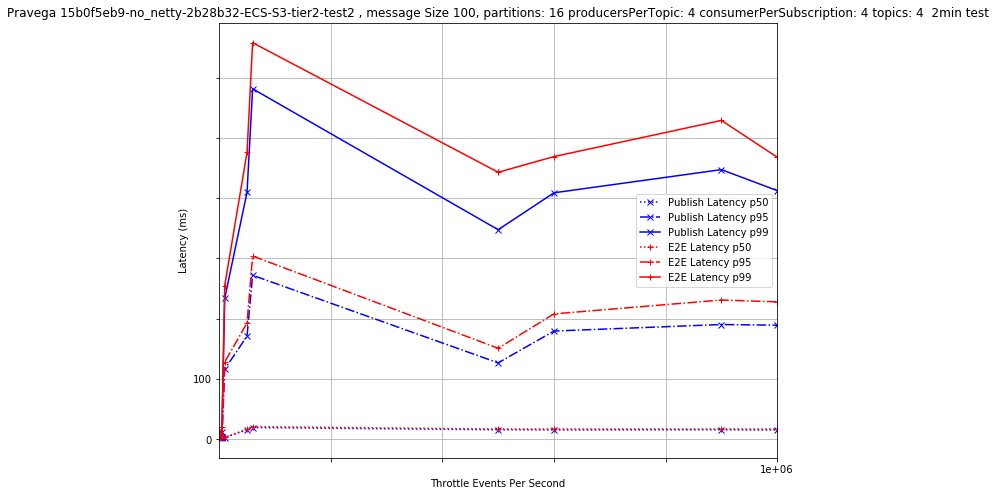

In [2808]:
plot_latency_vs_provided_rate_normal(filt_100_df)

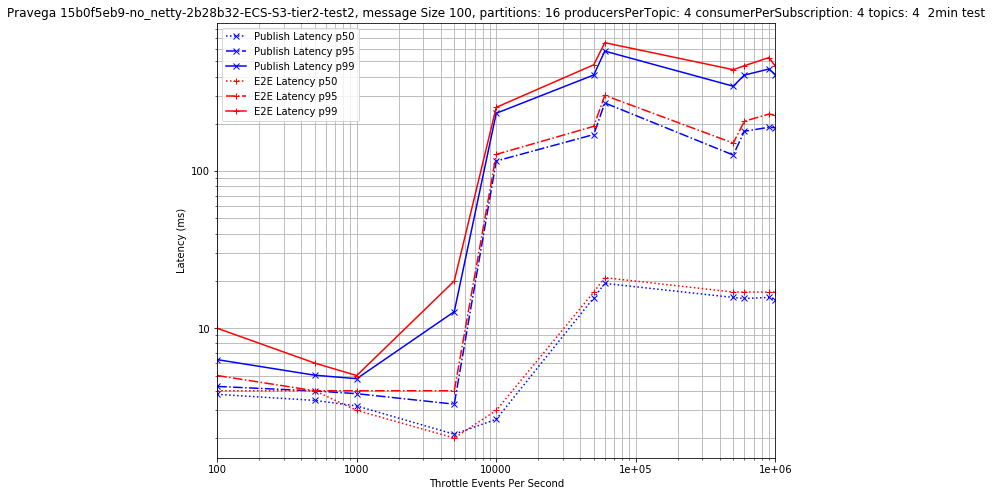

In [2809]:
plot_latency_vs_provided_rate(filt_100_df)

In [2810]:
latency_vs_provided_rate_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Throttle Events Per Second,,,,,,,
100.0,3.795,4.262,6.313,4.0,5.000,10.000,3f2141fb-a13a-4207-b2e8-e930afd9e156
500.0,3.472,3.990,5.024,4.0,4.000,6.000,540298fb-e99d-4ba7-97b1-4f87c942fcf4
1000.0,3.201,3.832,4.774,3.0,4.000,5.000,b9d36eb2-0596-45b4-a092-6c538ba20a51
5000.0,2.114,3.287,12.754,2.0,4.000,20.000,87837b63-0e02-4467-be56-75caf48c1b16
10000.0,2.632,116.135,233.816,3.0,128.000,255.000,4e08cb32-3034-4404-b127-48daf75353f5
50000.0,15.627,171.157,409.765,17.0,193.000,476.001,51e99d52-ae8d-4004-ad77-5885acbe3662
60000.0,19.304,272.033,581.523,21.0,304.001,658.003,a5ca20ca-affa-4c14-8132-e778933fb1f4
500000.0,15.710,126.716,347.681,17.0,151.000,443.001,05f06902-d5a2-4482-a972-bffa77821cac
600000.0,15.469,179.529,408.923,17.0,208.000,469.001,8030d69b-2744-4506-8331-8563a3943d10


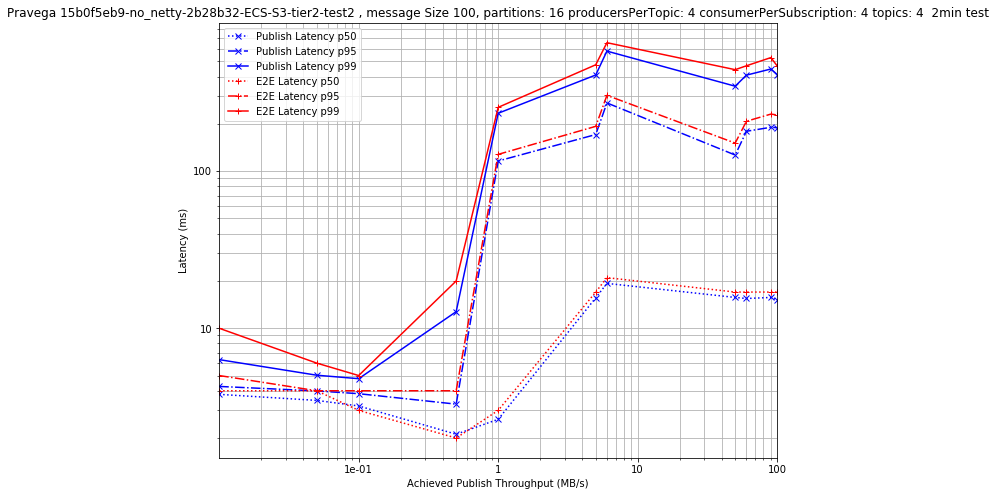

In [2811]:
plot_latency_vs_publish_throughput(filt_100_df)

In [2812]:
latency_vs_publish_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Publish Throughput (MB/s),,,,,,,
0.010013,3.795,4.262,6.313,4.0,5.000,10.000,3f2141fb-a13a-4207-b2e8-e930afd9e156
0.050077,3.472,3.990,5.024,4.0,4.000,6.000,540298fb-e99d-4ba7-97b1-4f87c942fcf4
0.100164,3.201,3.832,4.774,3.0,4.000,5.000,b9d36eb2-0596-45b4-a092-6c538ba20a51
0.500841,2.114,3.287,12.754,2.0,4.000,20.000,87837b63-0e02-4467-be56-75caf48c1b16
1.002136,2.632,116.135,233.816,3.0,128.000,255.000,4e08cb32-3034-4404-b127-48daf75353f5
5.015235,15.627,171.157,409.765,17.0,193.000,476.001,51e99d52-ae8d-4004-ad77-5885acbe3662
6.034166,19.304,272.033,581.523,21.0,304.001,658.003,a5ca20ca-affa-4c14-8132-e778933fb1f4
50.134580,15.710,126.716,347.681,17.0,151.000,443.001,05f06902-d5a2-4482-a972-bffa77821cac
60.373742,15.469,179.529,408.923,17.0,208.000,469.001,8030d69b-2744-4506-8331-8563a3943d10


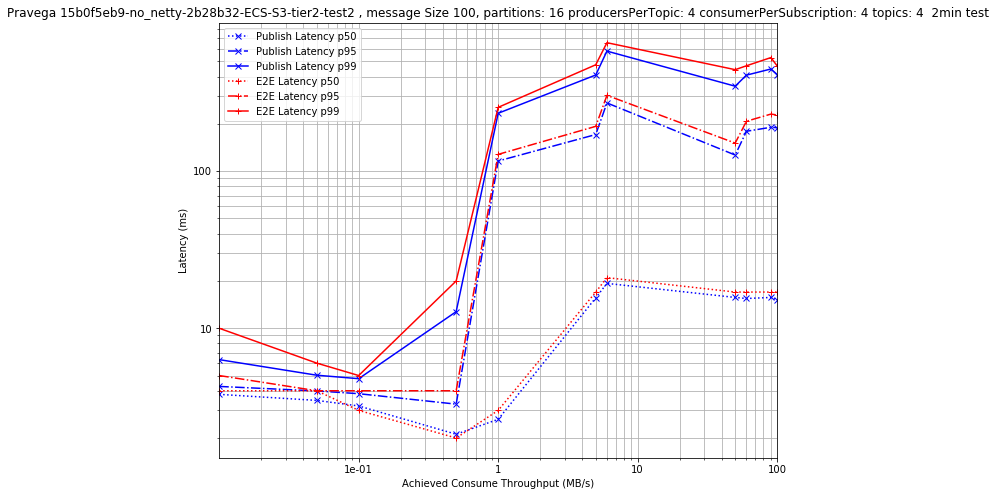

In [2813]:
plot_latency_vs_consume_throughput(filt_100_df)

In [2814]:
latency_vs_consume_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Consume Throughput (MB/s),,,,,,,
0.010012,3.795,4.262,6.313,4.0,5.000,10.000,3f2141fb-a13a-4207-b2e8-e930afd9e156
0.050081,3.472,3.990,5.024,4.0,4.000,6.000,540298fb-e99d-4ba7-97b1-4f87c942fcf4
0.100157,3.201,3.832,4.774,3.0,4.000,5.000,b9d36eb2-0596-45b4-a092-6c538ba20a51
0.500734,2.114,3.287,12.754,2.0,4.000,20.000,87837b63-0e02-4467-be56-75caf48c1b16
1.002155,2.632,116.135,233.816,3.0,128.000,255.000,4e08cb32-3034-4404-b127-48daf75353f5
5.015712,15.627,171.157,409.765,17.0,193.000,476.001,51e99d52-ae8d-4004-ad77-5885acbe3662
6.035313,19.304,272.033,581.523,21.0,304.001,658.003,a5ca20ca-affa-4c14-8132-e778933fb1f4
50.143300,15.710,126.716,347.681,17.0,151.000,443.001,05f06902-d5a2-4482-a972-bffa77821cac
60.374560,15.469,179.529,408.923,17.0,208.000,469.001,8030d69b-2744-4506-8331-8563a3943d10


## Message Size 10 KB

In [2760]:
filt_10000_df = filter_dataframe(
    filt_df,
    messageSize=10000,
    producersPerTopic=4,
    partitionsPerTopic=1,
    numWorkloadWorkers=4,
    version='2.6.0-ecs-s3-tier2'
    #version='2.6.0-not-tiered'
    #version='2.5.2',
    #version='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2'
    #version='15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2'
    #version='15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2-test2'
)

In [2761]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_10000_df[param_cols].drop_duplicates().T

test_uuid,c5283ef8-f09d-402d-805f-52ae7abf8e53
numWorkloadWorkers,4
topics,4
partitionsPerTopic,1
producersPerTopic,4
subscriptionsPerTopic,1
consumerPerSubscription,4
testDurationMinutes,2
keyDistributor,NO_KEY
git_commit,9de924e
driverName,Pulsar


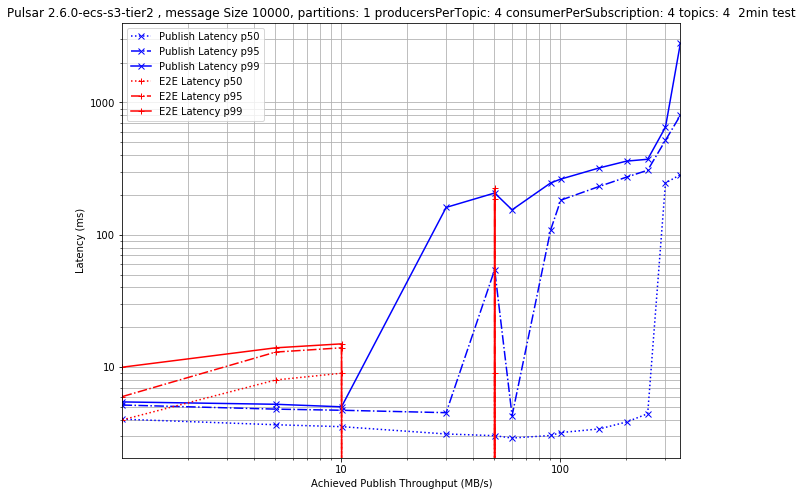

In [2762]:
plot_latency_vs_publish_throughput(filt_10000_df)

In [2763]:
latency_vs_publish_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Publish Throughput (MB/s),,,,,,,
1.001933,4.044,5.174,5.462,4.0,6.0,10.0,c5283ef8-f09d-402d-805f-52ae7abf8e53
5.010005,3.672,4.819,5.243,8.0,13.0,14.0,529a34f7-d108-45da-8751-c35f6dfd5835
10.019060,3.551,4.724,5.016,9.0,14.0,15.0,bb27155e-a617-4dff-b5d0-44d6078ccb18
30.096890,3.127,4.530,161.113,0.0,0.0,0.0,9cc3226c-5a8b-4050-851e-34760617d6cd
50.104752,3.036,54.489,206.913,9.0,186.0,224.0,79a76e6c-e2a2-495e-9d19-58921944b129
60.169238,2.914,4.303,154.436,0.0,0.0,0.0,0bf49e93-06f2-4ccd-901c-d880e5c8049e
90.320969,3.046,109.360,246.740,0.0,0.0,0.0,fd0991ae-8171-4d4a-a87d-a3263d88e910
100.336437,3.204,182.637,263.529,0.0,0.0,0.0,5255922a-5df0-4394-90d2-8a2343bbcfec
150.813024,3.416,232.392,320.503,0.0,0.0,0.0,930f0107-fa18-4343-afc0-0ce7686a5dc2


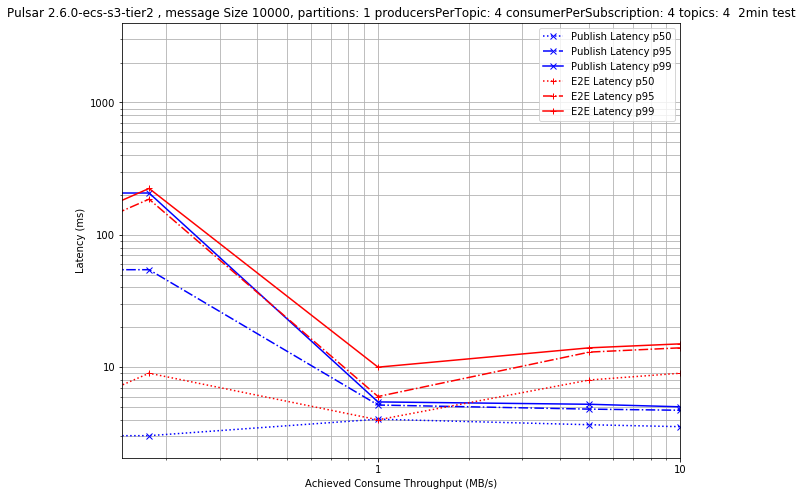

In [2764]:
plot_latency_vs_consume_throughput(filt_10000_df)

In [2765]:
latency_vs_consume_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Consume Throughput (MB/s),,,,,,,
0.000000,3.204,182.637,263.529,0.0,0.0,0.0,5255922a-5df0-4394-90d2-8a2343bbcfec
0.000000,2.914,4.303,154.436,0.0,0.0,0.0,0bf49e93-06f2-4ccd-901c-d880e5c8049e
0.000000,3.127,4.530,161.113,0.0,0.0,0.0,9cc3226c-5a8b-4050-851e-34760617d6cd
0.000000,3.046,109.360,246.740,0.0,0.0,0.0,fd0991ae-8171-4d4a-a87d-a3263d88e910
0.000000,3.416,232.392,320.503,0.0,0.0,0.0,930f0107-fa18-4343-afc0-0ce7686a5dc2
0.000000,246.133,517.585,650.323,0.0,0.0,0.0,ad5974af-adfc-4cc4-85ce-846d0efd4af1
0.000000,4.448,307.493,372.223,0.0,0.0,0.0,35a302fa-64dc-4b7a-8eae-88c3ae45e589
0.000000,285.213,802.607,2828.959,0.0,0.0,0.0,4e16f0ee-fb92-4020-9ede-89ec1a37b097
0.000000,3.854,272.923,360.435,0.0,0.0,0.0,ab3337e7-be56-49ef-8f44-8453d089feb3


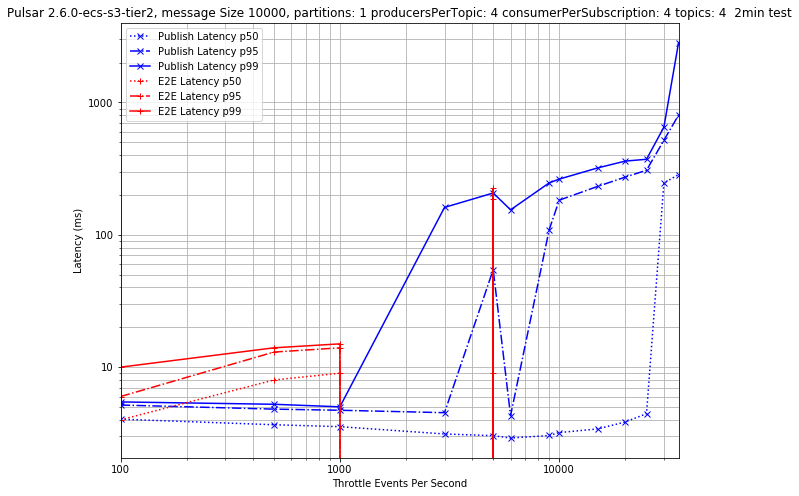

In [2766]:
plot_latency_vs_provided_rate(filt_10000_df)

In [2767]:
latency_vs_provided_rate_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Throttle Events Per Second,,,,,,,
100.0,4.044,5.174,5.462,4.0,6.0,10.0,c5283ef8-f09d-402d-805f-52ae7abf8e53
500.0,3.672,4.819,5.243,8.0,13.0,14.0,529a34f7-d108-45da-8751-c35f6dfd5835
1000.0,3.551,4.724,5.016,9.0,14.0,15.0,bb27155e-a617-4dff-b5d0-44d6078ccb18
3000.0,3.127,4.530,161.113,0.0,0.0,0.0,9cc3226c-5a8b-4050-851e-34760617d6cd
5000.0,3.036,54.489,206.913,9.0,186.0,224.0,79a76e6c-e2a2-495e-9d19-58921944b129
6000.0,2.914,4.303,154.436,0.0,0.0,0.0,0bf49e93-06f2-4ccd-901c-d880e5c8049e
9000.0,3.046,109.360,246.740,0.0,0.0,0.0,fd0991ae-8171-4d4a-a87d-a3263d88e910
10000.0,3.204,182.637,263.529,0.0,0.0,0.0,5255922a-5df0-4394-90d2-8a2343bbcfec
15000.0,3.416,232.392,320.503,0.0,0.0,0.0,930f0107-fa18-4343-afc0-0ce7686a5dc2


## Analyze 100 B events, 50,000 events/sec, various number of partitions and producers

In [2768]:
filt_50000eps_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producerRate=-1,
).sort_values(['endToEndLatencyMs99Pct'], ascending=True)
len(filt_50000eps_df)

filter_dataframe: No matching records after filtering on producerRate=[-1]


0

In [2605]:
take_varying_columns(filt_50000eps_df[cols]).head(20)

""
test_uuid


# Analyze Latency Distribution

In [2489]:
test_uuid = filt_50000eps_df.iloc[0].name
test_uuid

IndexError: single positional indexer is out-of-bounds

In [ ]:
df = clean_df
t = df[df.test_uuid==test_uuid].iloc[0]

In [ ]:
# Cumulative Distribution Function
pubcdf = t.aggregatedPublishLatencyQuantiles
pubcdf.name = 'Publish Latency CDF'

In [ ]:
# Probability Distribution Function (latency histogram)
pubpdf = pd.Series(index=pubcdf.index, data=np.gradient(pubcdf, pubcdf.index.values), name='Publish Latency PDF')

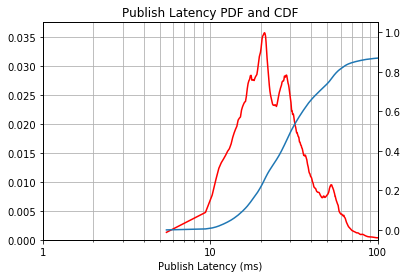

In [2490]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
pubpdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='Publish Latency PDF and CDF')
pubcdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('Publish Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [2491]:
# Cumulative Distribution Function
e2ecdf = t.aggregatedEndToEndLatencyQuantiles
e2ecdf.name = 'E2E Latency CDF'
# Probability Distribution Function (latency histogram)
e2epdf = pd.Series(index=e2ecdf.index, data=np.gradient(e2ecdf, e2ecdf.index.values), name='E2E Latency PDF')

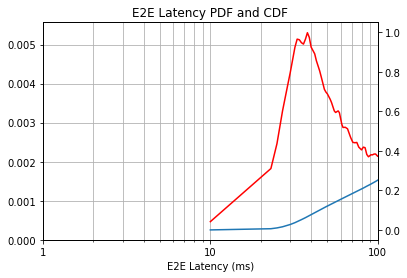

In [2492]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
e2epdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='E2E Latency PDF and CDF')
e2ecdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

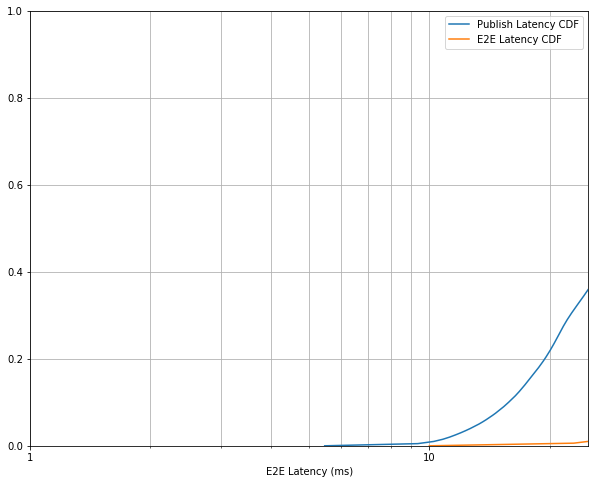

In [2493]:
# Combined publish and E2E latency CDF
fig0, ax0 = plt.subplots()
xlim=[1,25]
pubcdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True, figsize=(10,8))
e2ecdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True)
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

## Compare Two Sets

In [2499]:
# Common filter
filt_df = filter_dataframe(
    clean_df,
    numWorkloadWorkers=4, 
    topics=4,
    testDurationMinutes=2,
    #size_of_test_batch=(2,1000), # between
    #aggregatedEndToEndLatency50pct=(1,1e6),
    messageSize=100,
    producersPerTopic=4,
    partitionsPerTopic=1,    
)
len(filt_df)

43

In [2510]:
# Set 1
filt1_df = filter_dataframe(
    filt_df,
    #version='2.6.0-not-tiered',
    version='15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2',
    #pravegaVersion='15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2-test2',  
    #pravegaVersion='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2' 
    #pravegaVersion='0.8.0-2656.1c40f1e-Isilon-tier2',
)
len(filt1_df)

11

In [2511]:
# Set 2
filt2_df = filter_dataframe(
    filt_df,
    #version='2.6.0-ecs-s3-tier2'
    #version='2.5.2',
    #pravegaVersion='0.8.0-2656.1c40f1e-Isilon-tier2',
    #version='15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2',
    pravegaVersion='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2'
)
len(filt2_df)

11

In [2512]:
dfs = [filt1_df, filt2_df]
take_varying_columns(pd.concat(dfs)[param_cols]).drop_duplicates()

,git_commit,version
test_uuid,,
7bb5f7d4-9f6f-471b-9a25-91aa848126ae,b023619,15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2
a69af0c9-247e-4862-876b-b4a7fde5b323,88dbf86,0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2


In [2513]:
def plot_latency_vs_throughput_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    pravegaVersion = filt1_df.version.iloc[0]
    pravegaDriver = filt1_df.driver.iloc[0]
    pulsarVersion = filt2_df.version.iloc[0]
    pulsaraDriver = filt2_df.driver.iloc[0]
    messageSize = filt2_df.messageSize.iloc[0]
    msgSize = '%db' % (messageSize)
    if messageSize >= 1000:
        msgSize = '%dk' % (messageSize/1000)
    
    partitionsPerTopic = filt2_df.partitionsPerTopic.iloc[0]
    testDurationMinutes = filt2_df.testDurationMinutes.iloc[0]
    topics = filt2_df.topics.iloc[0]
    producersPerTopic = filt2_df.producersPerTopic.iloc[0]
    consumerPerSubscription = filt2_df.consumerPerSubscription.iloc[0]
    
    title = 'Compare %s %s and %s %s [messageSize %s, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d] on %d min test' % (pravegaDriver, pravegaVersion, pulsaraDriver, pulsarVersion, msgSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
   
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['publishRateMBPerSecMean']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
    
        plot_df = latency_vs_provided_rate_table(df)
        
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Achieved Publish Throughput (MB/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
                title=title 
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

In [2514]:
def plot_latency_vs_provided_rate_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    pravegaVersion = filt1_df.version.iloc[0]
    pravegaDriver = filt1_df.driver.iloc[0]
    pulsarVersion = filt2_df.version.iloc[0]
    pulsaraDriver = filt2_df.driver.iloc[0]
    messageSize = filt2_df.messageSize.iloc[0]
    msgSize = '%db' % (messageSize)
    if messageSize >= 1000:
        msgSize = '%dk' % (messageSize/1000)
    
    partitionsPerTopic = filt2_df.partitionsPerTopic.iloc[0]
    testDurationMinutes = filt2_df.testDurationMinutes.iloc[0]
    topics = filt2_df.topics.iloc[0]
    producersPerTopic = filt2_df.producersPerTopic.iloc[0]
    consumerPerSubscription = filt2_df.consumerPerSubscription.iloc[0]
    
    title = 'Compare %s %s and %s %s [messageSize %s, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d] on %d min test' % (pravegaDriver, pravegaVersion, pulsaraDriver, pulsarVersion, msgSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['throttleEventsPerSec']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
               
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Provided Rate (Events/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
                title=title 
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

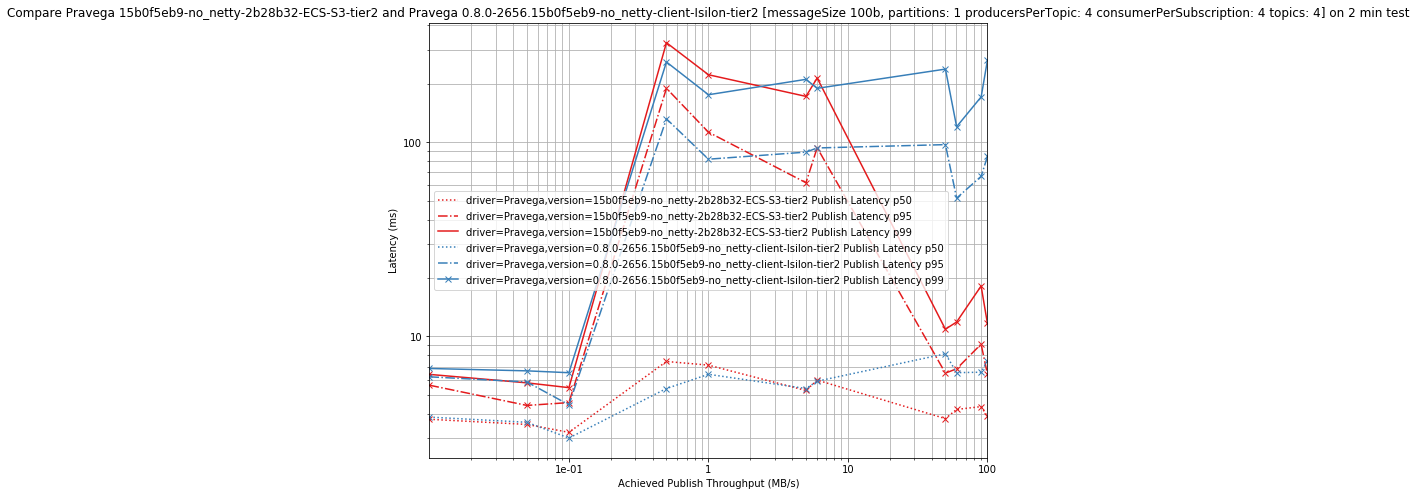

In [2515]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='Publish')

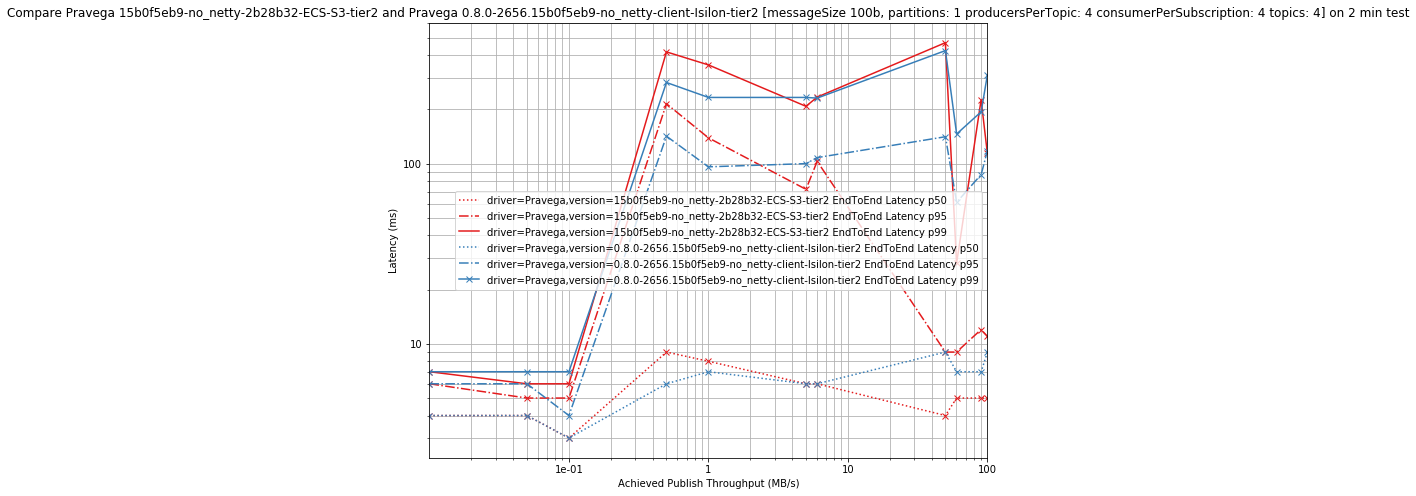

In [2516]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='EndToEnd')

In [2517]:
### Latency vs Provided Rate 

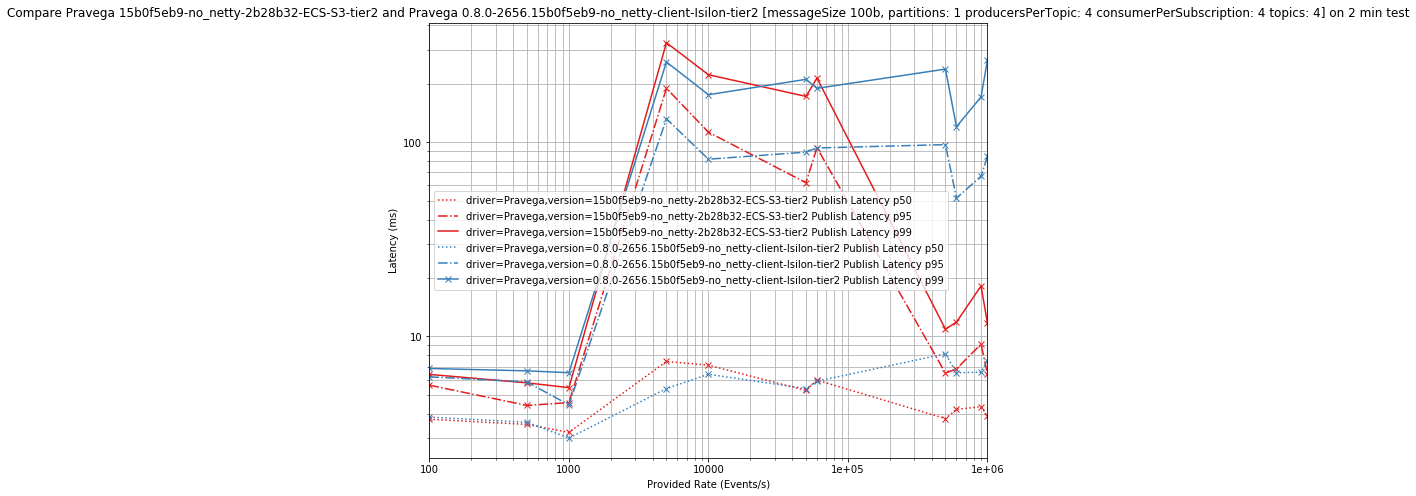

In [2518]:
plot_latency_vs_provided_rate_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='Publish')

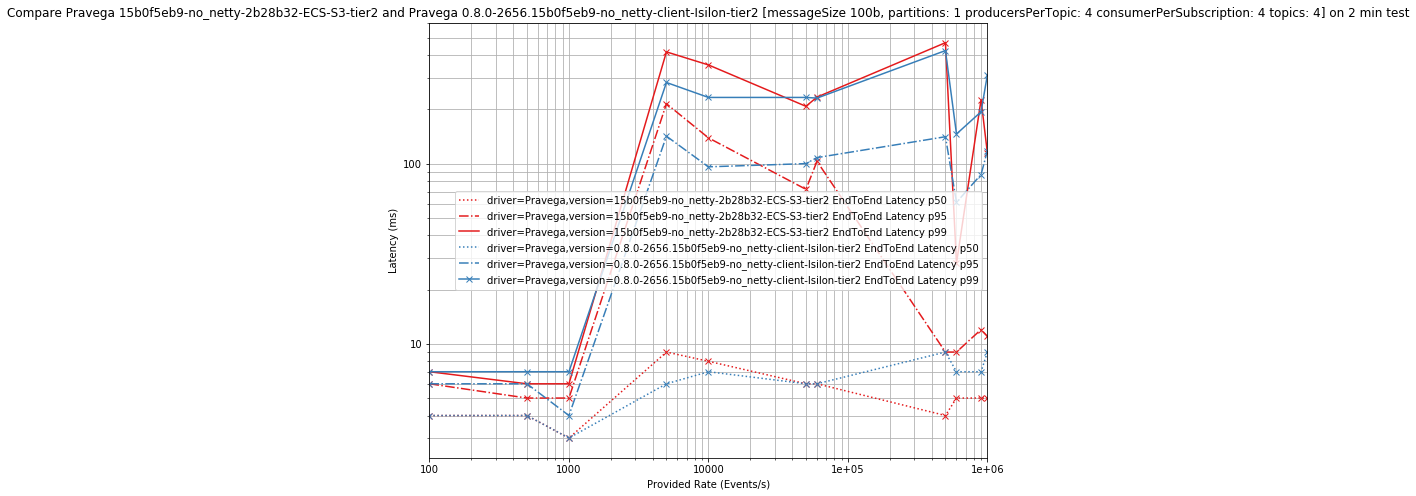

In [2519]:
plot_latency_vs_provided_rate_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='EndToEnd')